In [1]:
import glob
import time
import cv2
import pickle
import os.path
import random
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from time import sleep
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from scipy.ndimage.measurements import label


%matplotlib inline

### Functions for detecting lane line

In [2]:
def undistor_image(img, obj_points, img_points, build_pickle=False):
    """
    Undistort an image given obj_points, img_points
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pickle_path = "./camera_cal/wide_dist_pickle.p"
    if build_pickle or (not os.path.exists(pickle_path) ):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                           img_points,
                                                           (img.shape[1], img.shape[0]),
                                                           None, None)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        dist_pickle["ret"] = ret
        dist_pickle["rvecs"] = rvecs
        dist_pickle["tvecs"] = tvecs
        
        pickle.dump( dist_pickle, open( pickle_path, "wb" ) )

        return cv2.undistort(gray, mtx, dist, None, mtx)

    dist_pickle = pickle.load( open( pickle_path, "rb" ) )
    return cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])

def debug_images(img1, img2=None, title1="", title2=None):
    """
    Debug image by showing a set the titles
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1, fontsize=40)
    if img2 != None:
        ax2.imshow(img2, cmap='gray')
        ax2.set_title(title2, fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Returns binary output of image, filtering out pixels
    that are not in the desired direction(tresh)
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    arc_xy = np.arctan2(abs_y, abs_x)
    binary_output = np.zeros_like(arc_xy)
    binary_output[(arc_xy >= thresh[0]) & (arc_xy <= thresh[1])] = 1

    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Apply sobel to an image in given direction
    returns binary image filtered by thresholds
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    derivative = (1, 0)

    if orient == 'y':
        derivative = (0, 1)

    sobel = cv2.Sobel(gray, cv2.CV_64F, derivative[0], derivative[1], ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Returns binary image, filters out by magnitude
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(x**2 + y**2)
    scaled = np.uint8(mag/(np.max(mag)/255))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1

    return binary_output

def sobel(image, ksize=3, xy_thresh=(20, 255), mag_thresh_=(20, 200), dir_thresh=(0.3, 1.2)):
    """
    Returns a filtered binary image combining sobel in x and y
    magnitude and direction
    """
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=xy_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=xy_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=mag_thresh_)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return  combined

def channel_thresh(channel, thresh=(20, 255)):
    """
    Returns a filtered channel i.e one the RGB or HSV etc
    """
    ch_binary = np.zeros_like(channel)
    ch_binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return ch_binary

def color_and_gradient_comb(img, debug=(False, False)):
    """
    Returns a combination gradient of image and selected channels
    """
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    s1_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    s2_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    R_channel = img[:,:, 0]
 
    s1_channel_bin = channel_thresh(s1_channel, thresh=(160, 255))
    s2_channel_bin = channel_thresh(s2_channel, thresh=(150, 255))
    l_channel_bin  = channel_thresh(l_channel, thresh=(220, 255))
    v_channel_bin  = channel_thresh(v_channel, thresh=(110, 255))
    R_channel_bin  = channel_thresh(R_channel, thresh=(210, 255))
    comb_channel = np.zeros_like(s1_channel_bin)
    comb_channel[((s1_channel_bin == 1)|
                 (s2_channel_bin == 1) |
                 (l_channel_bin == 1)) &
                 (v_channel_bin == 1)  |
                 (R_channel_bin == 1)] = 1
    
    #sobel on x and y, mag and dir
    dxdy_img = sobel(img, ksize=3, xy_thresh=(30, 250), mag_thresh_=(30, 250), dir_thresh=(-1.0, 1.0))

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    stacked = np.dstack(( np.zeros_like(dxdy_img), dxdy_img, comb_channel))
    all_comb = np.zeros_like(dxdy_img)
    all_comb[(dxdy_img == 1) | (comb_channel == 1)] = 1
     
    if debug[0] or debug[1]:
        #plot original image
        if debug[0]:
        #plot channels vs binaries
            debug_images(s1_channel, s1_channel_bin, 'S1 CH', 'S1 BIN')
            debug_images(s2_channel, s2_channel_bin, 'S2 CH', 'S2 BIN')
            debug_images(l_channel, l_channel_bin, 'L CH', 'L BIN')
            debug_images(v_channel, v_channel_bin, 'V CH', 'V BIN')
            debug_images(R_channel, R_channel_bin, 'R CH', 'R BIN')
        #plot gradient vs channel comb
        if debug[1]:
            debug_images(dxdy_img, comb_channel, 'Derivative', 'Channel')
            #plot stacked of gradient and channel combinations
            debug_images(stacked, all_comb, 'Stacked dx+comb', 'Combined dx+comb')
        debug_images(img, img, 'IMG', 'IMG')

    return all_comb

def warp(img, debug=False):
    """
    Returns a warped image and its inverse Matrix
    """
    img = np.copy(img)
    shape = img.shape

    src = np.float32(
        [
            [.55*shape[1], .64*shape[0]],
            [.45*shape[1], .64*shape[0]],
            [.15*shape[1], shape[0]],
            [.88*shape[1], shape[0]]
        ])
    _src = src.reshape((-1,1,2)).astype(int)
    _input = cv2.polylines(np.copy(img),[_src],True,(255,0,0), 2)

    dst = np.float32(
        [
            [.75*shape[1], 0],
            [.25*shape[1], 0],
            [.25*shape[1], shape[0]],
            [.75*shape[1], shape[0]]
        ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (shape[1], shape[0]), flags=cv2.INTER_LINEAR)
    _dst = dst.reshape((-1,1,2)).astype(int)
    _out_put = cv2.polylines(np.copy(warped),[_dst],True,(255,0,0), 2)

    if debug:
        debug_images(_input, _out_put, 'input', 'warped')
    return (np.uint8(warped), Minv)

def radius(ploty, leftx, rightx, height_m=30.0, width_m=3.7, height_px=720.0, width_px=1280.0):
    """
    Compute the radius of a line
    """
    y_eval = np.max(ploty)
    
    ym_per_pix = height_m/height_px
    xm_per_pix = width_m/width_px
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    middle = (leftx[-1] + rightx[-1])//2
    carpos = ((width_px//2) - middle)*xm_per_pix
    return (left_curverad, right_curverad, carpos)

def plot_lane_area(warped, undist, Minv, ploty, left_fitx, right_fitx, debug=False):
    """
    Plots the area between lane lines
    """
    warp_zero = np.zeros_like(warped).astype(np.uint8) * 255
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    if debug:
        plt.figure()
        plt.imshow(result)
        plt.figure()
        plt.imshow(np.uint8(newwarp))
    return result

def find_lane_line(binary_warped, debug=False, boxes=False):
    """
    Find lane lines equations base on warped image
    """
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 10
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if boxes:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 22) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if debug:
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow', markersize=12)
        plt.plot(right_fitx, ploty, color='yellow', markersize=12)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    data = {
        "out_img": out_img,
        "left_fit": left_fit,
        "right_fit": right_fit,
        "left_fitx": left_fitx,
        "right_fitx": right_fitx,
        "ploty": ploty
    }
    
    return data

def find_second_frame(binary_warped, left_fit, right_fit, debug=False):
    """
    Find lane lines of next frame base on last left and right fits
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    if debug:
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
        
    data = {
        "out_img": out_img,
        "left_fit": left_fit,
        "right_fit": right_fit,
        "left_fitx": left_fitx,
        "right_fitx": right_fitx,
        "ploty": ploty
    }
    return data

class Line():
    def __init__(self):
        self.detected = False  
        self.recent_xfitted = [] 
        self.bestx = None     
        self.best_fit = None  
        self.current_fit = [np.array([False])]  
        self.line_base_pos = None 
        self.diffs = np.array([0,0,0], dtype='float') 
        self.allx = None  
        self.ally = None
        data = None
        radius_and_pos = (1,1,1)

    def check_first_time(self):
        self.detected = True
        self.last_data = self.data
        self.radius_and_pos = radius(self.data["ploty"],
                        self.data["left_fitx"],
                        self.data["right_fitx"],
                        height_m=30.0, width_m=3.7,
                        height_px=720.0, width_px=1200.0)

    def check(self):
        self.radius_and_pos = radius(self.data["ploty"],
                        self.data["left_fitx"],
                        self.data["right_fitx"],
                        height_m=30.0, width_m=3.7,
                        height_px=720.0, width_px=1200.0)

## Section includes vehicle detection functions

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv != 'RGB':
        if conv == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img) 

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file, format="jpg")
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv=color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, conv=color_space)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, debug=False):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        if debug:
            debug_images(test_img, title1="window: {}, predict: {}".format(window, prediction))
            
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


### training classifier to detect vehicles

In [6]:
cars = glob.glob("img/train/vehicles/**/*.png")
notcars = glob.glob("img/train/non-vehicles/**/*.png")
random.shuffle(cars)
random.shuffle(cars)
random.shuffle(notcars)
random.shuffle(notcars)

sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]


color_space = "YUV" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, 656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 10000)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.4, random_state=rand_state)

#tuned_parameters = [{'kernel': ['sigmoid'], 'gamma': [ 0.0001, 0.00003], 'C': [ 0.5, 1 ]}]
#clf = GridSearchCV(SVC(verbose=True), tuned_parameters, cv=4)

clf = SVC(verbose=True, gamma=0.0001, C=0.5, kernel="rbf")

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

#print("Best Parameters")
#print(clf.best_params_)


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
[LibSVM]67.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9942


In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heat_windows(image, box_list, limit, debug=False, heat_flag=False):
    image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,limit)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if debug:
        plt.imshow(draw_img)
        plt.title('Car Positions')
        fig = plt.figure()
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig = plt.figure()
    if heat_flag:
        return draw_img, heatmap, labels
    return draw_img

In [8]:
def detect_windows(image, plot=False):
    draw_image = np.copy(image)


    y_start_stop = [380, 600]
    x_start_stop = [540, image.shape[1]]
    windows1 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(.5, .5))

    y_start_stop = [380, image.shape[0]]
    x_start_stop = [240, image.shape[1]]
    windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(100, 100), xy_overlap=(.6, .8))

    y_start_stop = [380, image.shape[0]]
    x_start_stop = [240, image.shape[1]]
    windows3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(200, 200), xy_overlap=(.6, .6))

    windows = windows1 + windows2 + windows3


    if plot:
        window_img_ = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
        plt.imshow(window_img_)
    return windows


def find_vehicles(image, clf, not_heat=False):
    draw_image = np.copy(image)
    windows = detect_windows(image)

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, debug=False)                       

    window_img = heat_windows(draw_image, hot_windows, 2)
    if not_heat:
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    return window_img

In [9]:
images_path = glob.glob("./test_images/*.jpg")
tests = [mpimg.imread(path) for path in images_path]

444


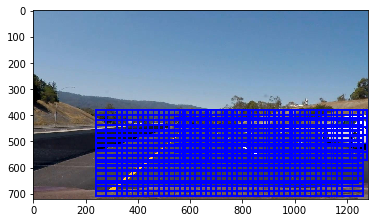

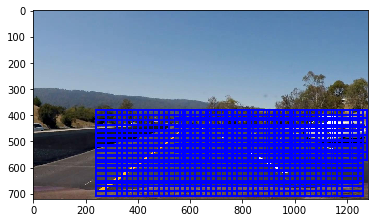

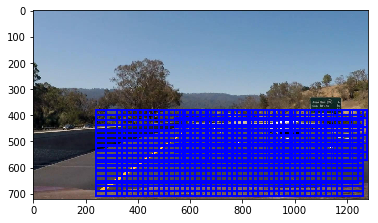

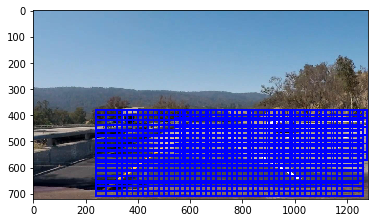

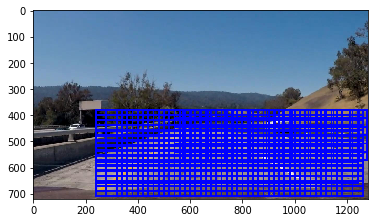

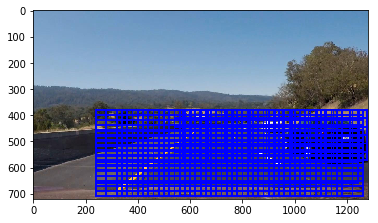

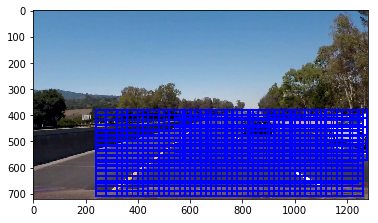

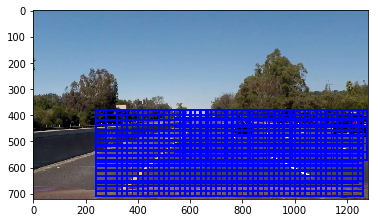

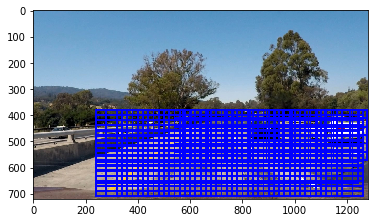

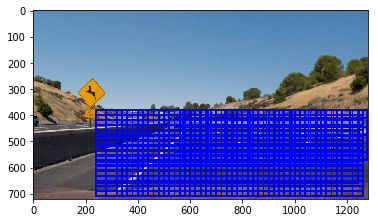

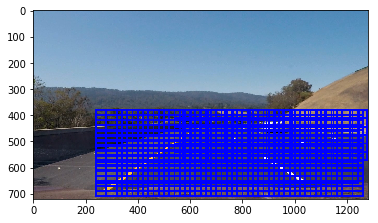

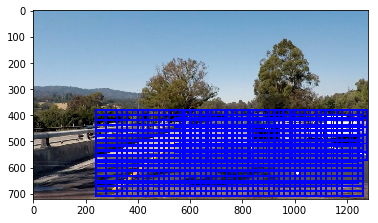

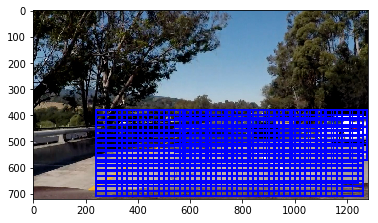

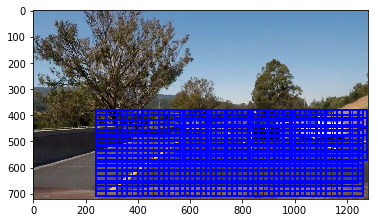

In [10]:
test = tests[3] #mpimg.imread("./test_images/test6.jpg")
for test in tests:
    ww=detect_windows(test, plot=True)
    plt.figure()
print(len(ww))

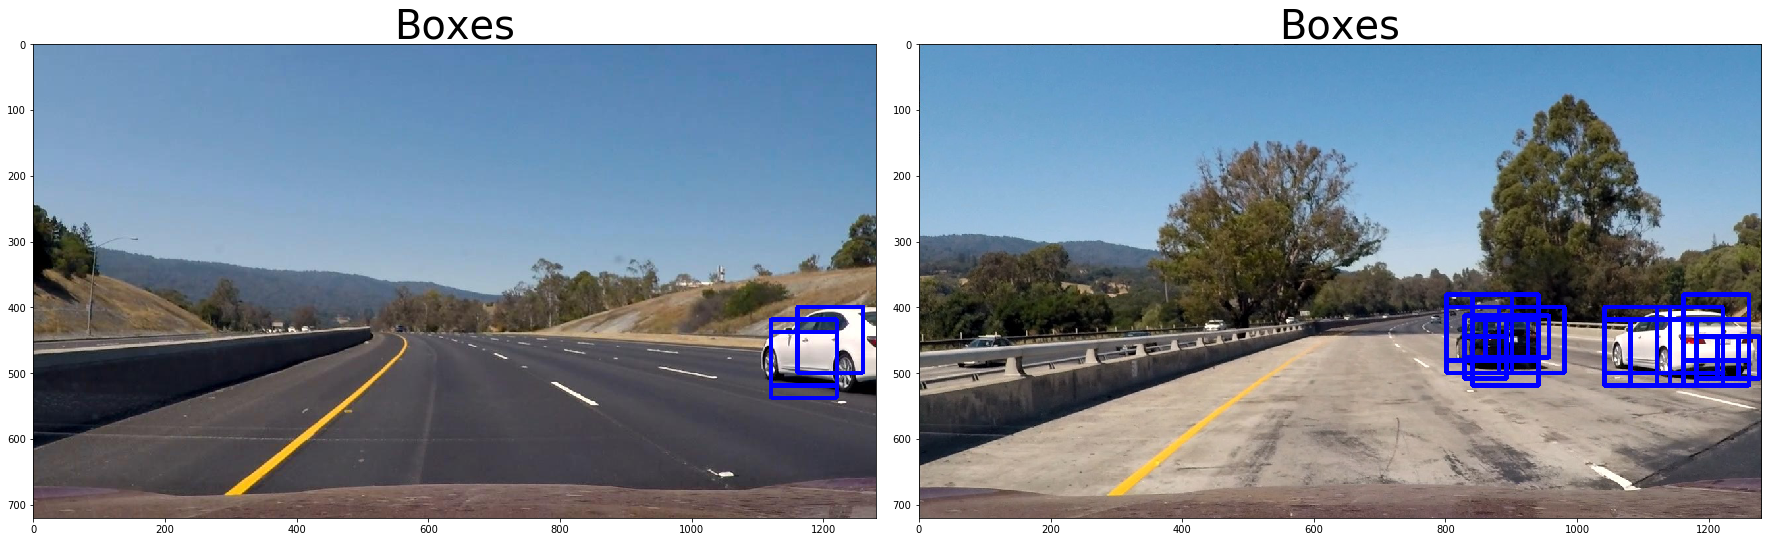

In [11]:
debug_images(find_vehicles(tests[0], clf, not_heat=True), find_vehicles(tests[8], clf, not_heat=True), "Boxes", "Boxes")

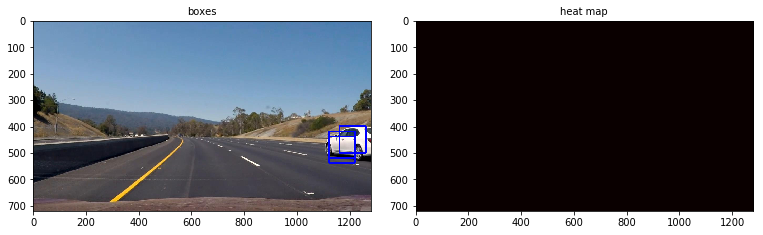

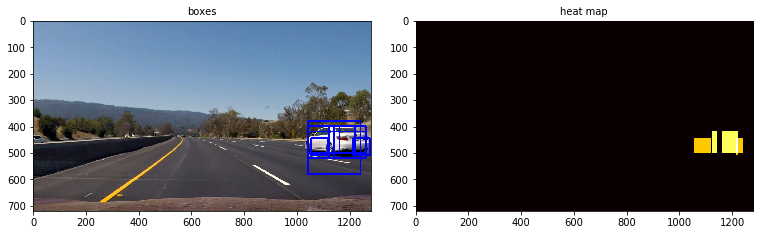

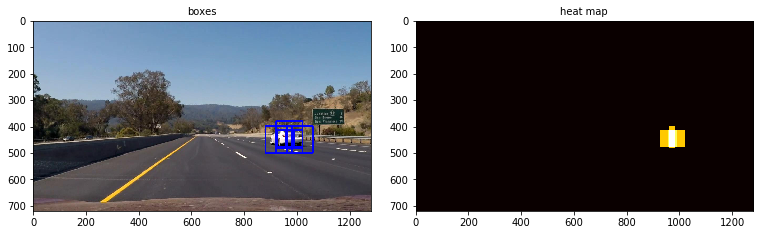

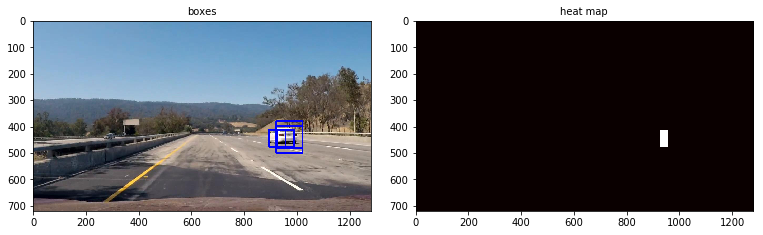

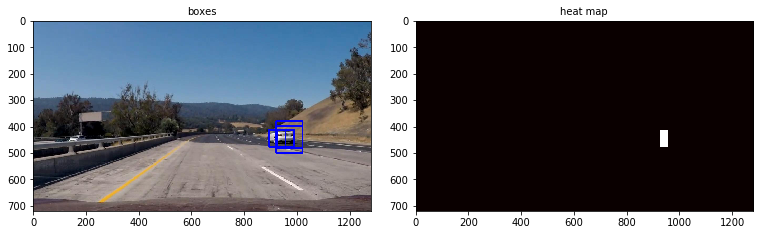

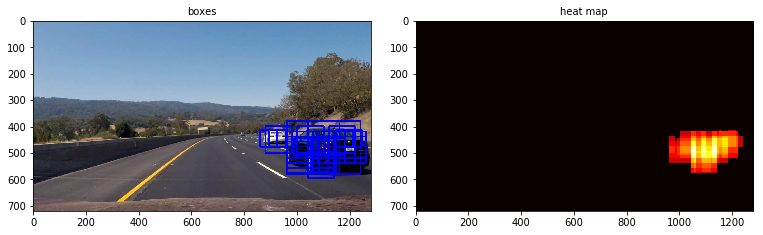

In [24]:
llabels = []
for test in tests[:6]:
    draw_image = np.copy(test)
    windows = detect_windows(test)

    hot_windows = search_windows(test, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, debug=False)                       
    bboxed_im = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    _, heat, labels = heat_windows(draw_image, hot_windows, 3, heat_flag=True)
    llabels.append(labels[0])
    llabels.append(labels[0])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(bboxed_im, cmap='gray')
    ax1.set_title("boxes", fontsize=10)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title("heat map", fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

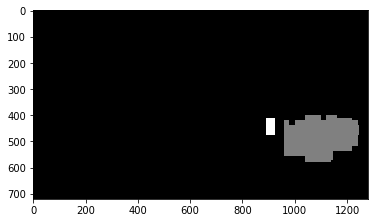

In [13]:
labels = llabels[0]
for l in llabels:
    labels =+ l
plt.imshow(labels, cmap="gray")

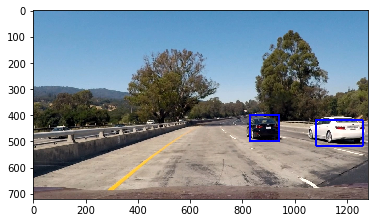

In [14]:
plt.imshow(find_vehicles(tests[8], clf))

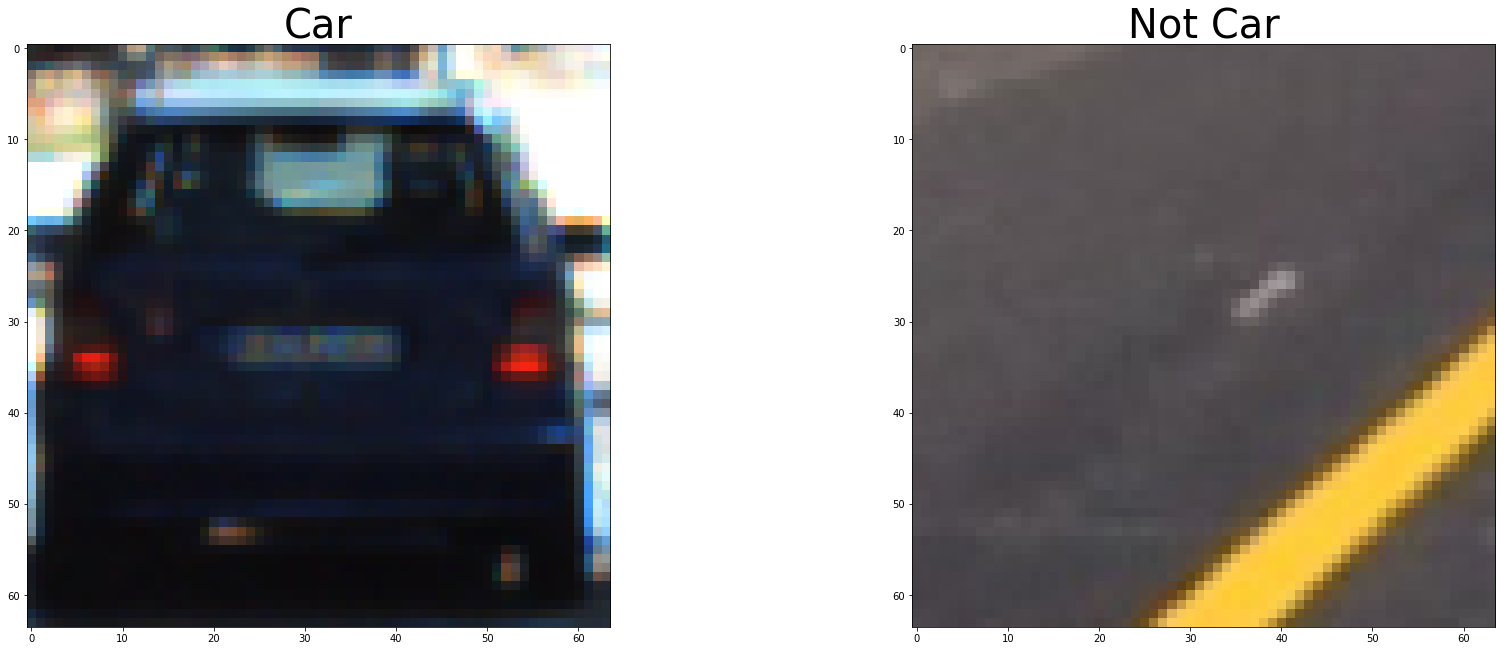

In [15]:
im1 = mpimg.imread(cars[1000], format="jpg")
im2 = mpimg.imread(notcars[1331], format="jpg")
debug_images(im1, im2, "Car", "Not Car")

In [16]:
def plot4(i1, i2, i3, i4):
    im1 = i1[0]
    t1  = i1[1]
    im2 = i2[0]
    t2  = i2[1]
    im3 = i3[0]
    t3  = i3[1]
    im4 = i4[0]
    t4  = i4[1]


    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(im1, cmap='gray')
    ax1.set_title(t1, fontsize=15)
    ax2.imshow(im2, cmap='gray')
    ax2.set_title(t2, fontsize=15)
    ax3.imshow(im3, cmap='gray')
    ax3.set_title(t3, fontsize=15)
    ax4.imshow(im4, cmap='gray')
    ax4.set_title(t4, fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

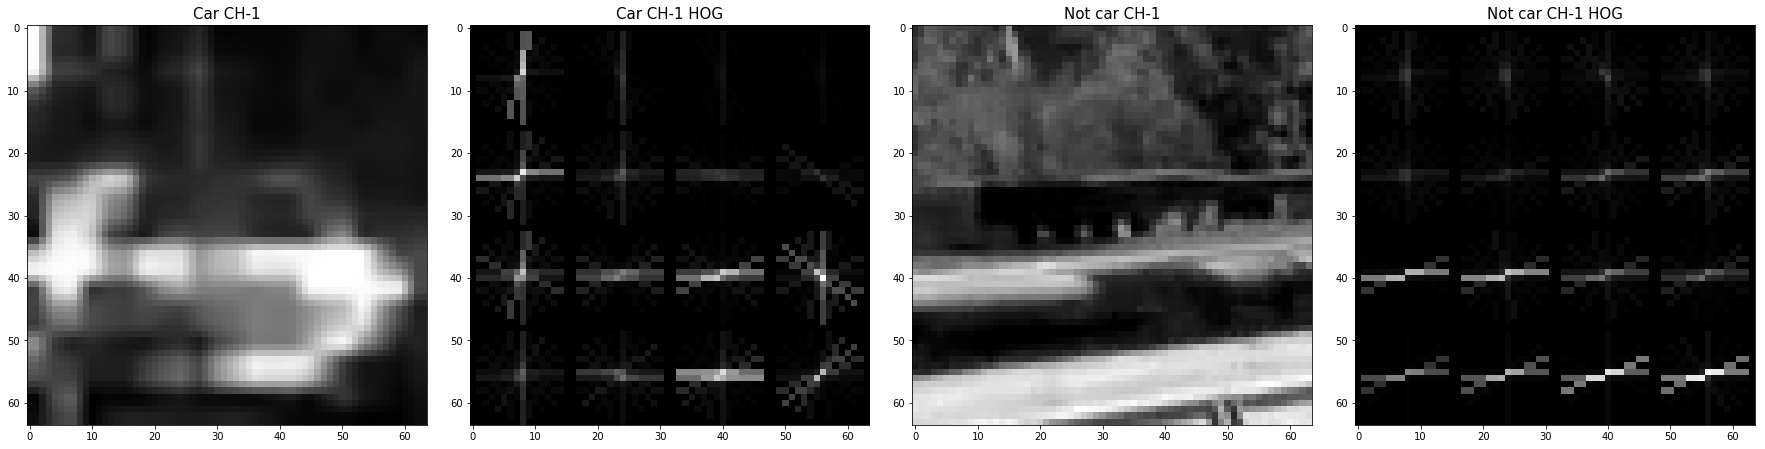

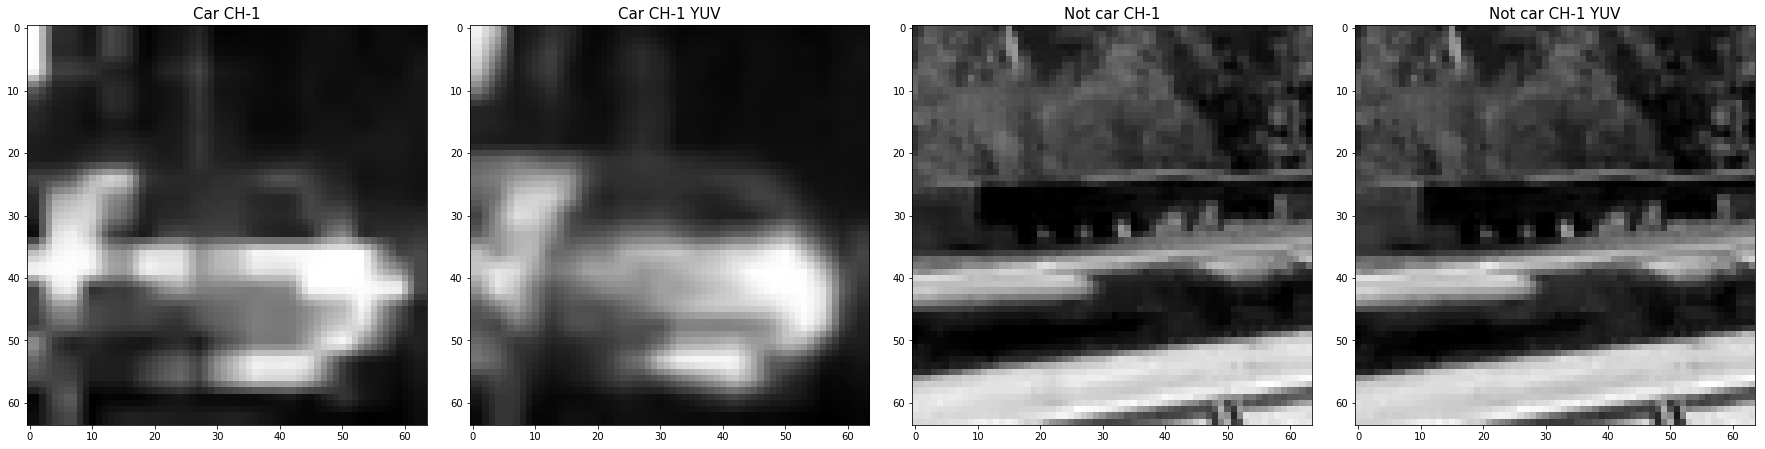

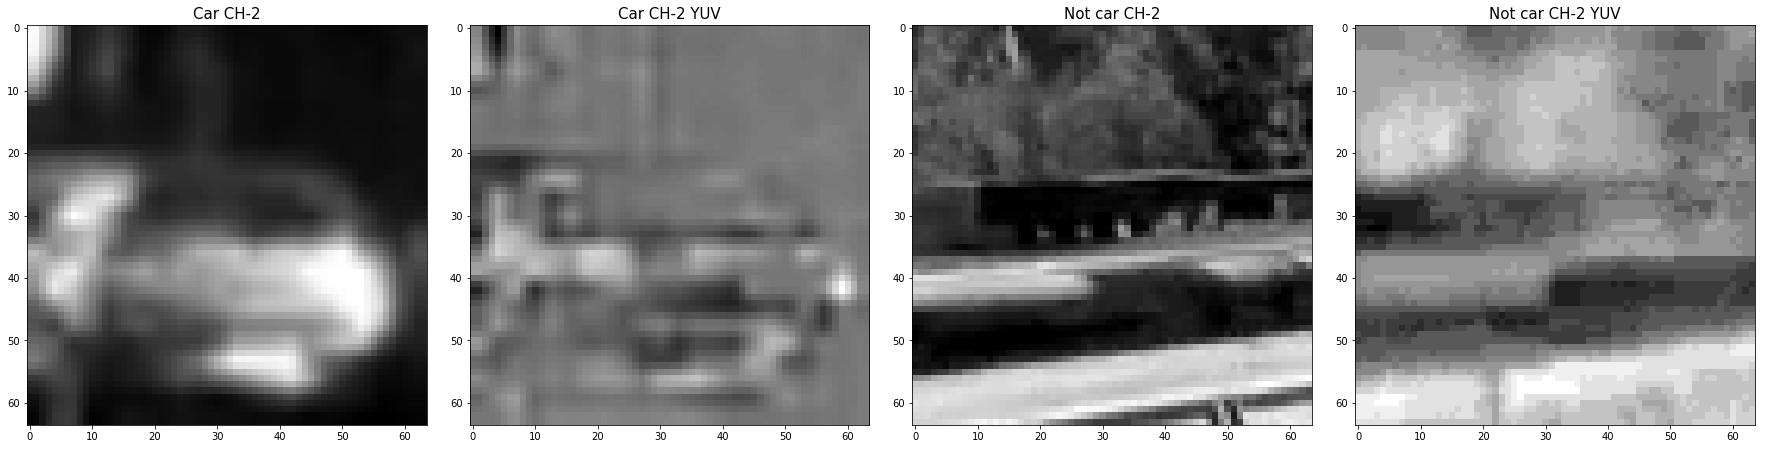

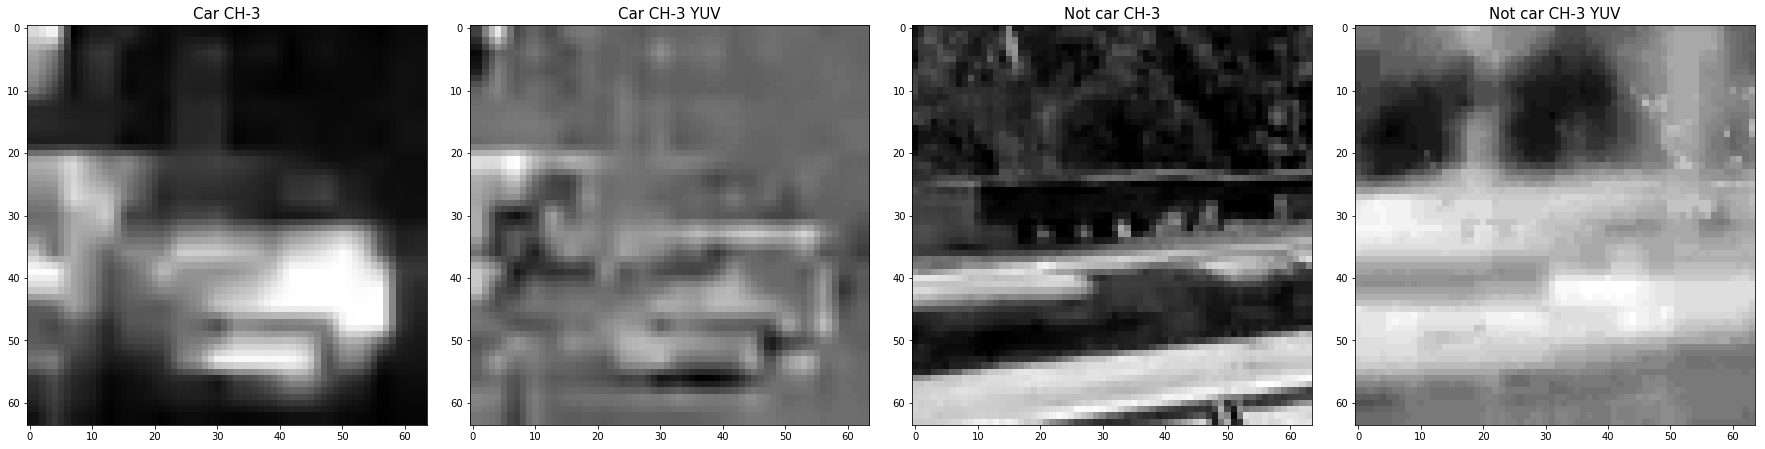

In [17]:
im1 = mpimg.imread(cars[865], format="jpg")
im2 = mpimg.imread(notcars[865], format="jpg")
im1yuv = cv2.cvtColor(im1, cv2.COLOR_RGB2YUV)
im2yuv = cv2.cvtColor(im2, cv2.COLOR_RGB2YUV)

orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

_, im1vis = hog(im1yuv[:,:,0], orientations=orient,
                     pixels_per_cell=(pix_per_cell, pix_per_cell),
                     cells_per_block=(cell_per_block, cell_per_block), 
                     transform_sqrt=False, 
                     visualise=True, feature_vector=True)

_, im2vis = hog(im2yuv[:,:,0], orientations=orient,
                     pixels_per_cell=(pix_per_cell, pix_per_cell),
                     cells_per_block=(cell_per_block, cell_per_block), 
                     transform_sqrt=False, 
                     visualise=True, feature_vector=True)

plot4((im1[:,:,0], "Car CH-1"),
      (im1vis, "Car CH-1 HOG"),
      (im2[:,:,0], "Not car CH-1"),
      (im2vis, "Not car CH-1 HOG"),
     )

plot4((im1[:,:,0], "Car CH-1"),
      (im1yuv[:,:,0], "Car CH-1 YUV"),
      (im2[:,:,0], "Not car CH-1"),
      (im2yuv[:,:,0], "Not car CH-1 YUV"),
     )

plot4((im1[:,:,1], "Car CH-2"),
      (im1yuv[:,:,1], "Car CH-2 YUV"),
      (im2[:,:,1], "Not car CH-2"),
      (im2yuv[:,:,1], "Not car CH-2 YUV"),
     )

plot4((im1[:,:,2], "Car CH-3"),
      (im1yuv[:,:,2], "Car CH-3 YUV"),
      (im2[:,:,2], "Not car CH-3"),
      (im2yuv[:,:,2], "Not car CH-3 YUV"),
     )

In [18]:
corners_pickle = pickle.load( open( "./camera_cal/corners_pickle.p", "rb" ) )
objpoints, imgpoints = (corners_pickle["objpoints"], corners_pickle["imgpoints"])
line = Line()

In [19]:
def process_image(image, debug=False, stacked=True):
    """
    Procces each frame of the video and return
    The plotted lane lane area over the image.
    """
    undistort = undistor_image(image, objpoints, imgpoints, build_pickle=False)
    binary = color_and_gradient_comb(undistort, debug=(False, False))
    warped, Minv = warp(binary, debug=False)

    if line.detected:
        line.data = find_second_frame(warped, line.data["left_fit"], line.data["right_fit"], debug=False)
        line.check()
    else:
        line.data = find_lane_line(warped, debug=False)
        line.check_first_time()

    plotted = plot_lane_area(warped, undistort, Minv, line.data["ploty"], line.data["left_fitx"], line.data["right_fitx"], debug=False)
    plotted = find_vehicles(plotted, clf)
    # Write Curvature Radius on image
    color=[0, 255, 0]
    lr, rr, pos = line.radius_and_pos
    direction = "left" if pos < 0 else "right"
    lcaption = "L[Curvature Radius={0}Km.]".format( round(lr/1000.0, 2) )
    rcaption = "R[Curvature Radius={0}Km.]".format( round(rr/1000.0, 2) )
    poscaption = "Positon {}m {} of the center".format(round(abs(pos),2), direction )
    if not stacked:
        cv2.putText(plotted, lcaption,(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,color,1,cv2.LINE_AA)
        cv2.putText(plotted, rcaption,(10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1,color,1,cv2.LINE_AA)
        cv2.putText(plotted, poscaption,(10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1,color,1,cv2.LINE_AA)
    

    #if want to make video with binary or warped images
    if stacked:
        b = np.uint8(binary)
        bbb = np.dstack((b, b, b))*255
        w = np.uint8(warped)
        www = np.dstack((w, w, w))*255
        bbb = cv2.resize(bbb, (426, 240))
        www = cv2.resize(www, (426, 240))
        fill = cv2.resize(np.zeros_like(bbb), (428, 240) )
        
        cv2.putText(fill, lcaption,(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8,color,1,cv2.LINE_AA)
        cv2.putText(fill, rcaption,(10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.8,color,1,cv2.LINE_AA)
        cv2.putText(fill, poscaption,(10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color,1,cv2.LINE_AA)
        cv2.putText(fill, "<--- binary gradient + channels",(10, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color,1,cv2.LINE_AA)
        cv2.putText(fill, "bird's eye view perspective --->",(10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.7,color,1,cv2.LINE_AA)
        
        bw = np.concatenate((bbb, fill ,www), axis=1)
        return np.concatenate((plotted, bw), axis=0)


    return find_vehicles(np.copy(plotted), clf)

In [20]:
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile('test.mp4', audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


 97%|█████████▋| 38/39 [02:46<00:04,  4.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 2min 44s, sys: 4.24 s, total: 2min 48s
Wall time: 2min 47s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="test.mp4">
</video>
""")

In [25]:
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile('project_out.mp4', audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|█████████▉| 1260/1261 [1:31:53<00:04,  4.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 

CPU times: user 1h 30min 54s, sys: 2min 18s, total: 1h 33min 12s
Wall time: 1h 31min 54s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_out.mp4">
</video>
""")